# Titanic Competition 

## 1 Explore Dataset

### 1.1 Load all necessary data + libraries

In [82]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import time
# magic word for producing visualizations in notebook
%matplotlib inline

#scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb

In [83]:
# load in the data
train = pd.read_csv('data/train.csv', sep=',')

In [84]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [85]:
train.shape

(891, 12)

### 1.2 Survived by Class

The first thought that came to my mind was that most probably the survival chance depended on class. So we can group people from dataset by class to which they belonged and chack the survival rate.

In [86]:
stats_by_class = train.groupby('Pclass')['Survived'].value_counts()
stats_by_class

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

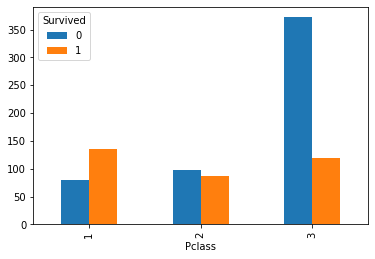

In [87]:
stats_by_class.unstack(level=1).plot(kind='bar', subplots=False)

Indeed, most people from the first class survived and from 3rd parished.

### 1.3 Survived by Sex

The next idea is to verify wether more women survived rather than men. It is actually, very logical, because children and women were first to board the lifeboats.  

In [88]:
stats_by_sex = train.groupby('Pclass')['Sex'].value_counts()
stats_by_sex

Pclass  Sex   
1       male      122
        female     94
2       male      108
        female     76
3       male      347
        female    144
Name: Sex, dtype: int64

From data it turned out that there were more man than women on board of Titanic in general.

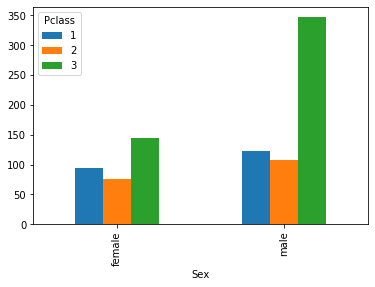

In [89]:
stats_by_sex.unstack(level=0).plot(kind='bar', subplots=False)

In [90]:
survived_by_sex = train.groupby('Sex')['Survived'].value_counts()
survived_by_sex

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

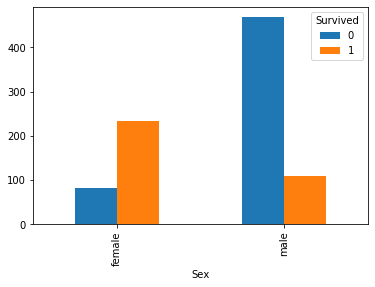

In [91]:
survived_by_sex.unstack(level=1).plot(kind='bar', subplots=False)

From the graph above we may conclude, that Sex had an impact on the survival chance. There were more woomen among survivors. "A disproportionate number of men were left aboard because of a "women and children first" protocol for loading lifeboats." [Wikipedia](https://en.wikipedia.org/wiki/Titanic)

### 1.4 Survived by place of the embarkment

After leaving Southampton on 10 April 1912 with 922 passengers on board, Titanic headed at Cherbourg in France and Queenstown (now Cobh) in Ireland, before heading west to New York.

In [92]:
survived_by_embarked = train.groupby('Embarked')['Survived'].mean()
survived_by_embarked

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

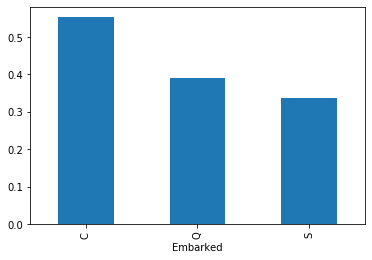

In [93]:
survived_by_embarked.plot(kind='bar', subplots=False)

It turns out that most passenger who were picked up in Cherbourg survived.

### 1.5 Family size

In [94]:
survived_by_SibSp = train.groupby('SibSp')['Survived'].mean()
survived_by_SibSp

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

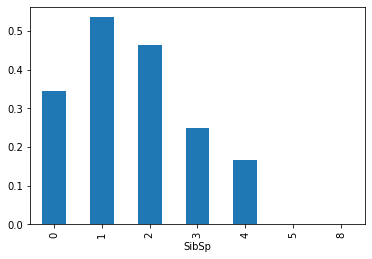

In [95]:
survived_by_SibSp.plot(kind='bar', subplots=False)

In [96]:
survived_by_Parch = train.groupby('Parch')['Survived'].mean()
survived_by_Parch

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

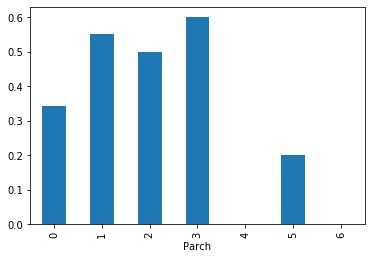

In [97]:
survived_by_Parch.plot(kind='bar', subplots=False)

In [98]:
#derive new feature "family size" by adding number of parents and siblings
def count_family_members(df):
    df['Fml_size'] = df['Parch'] + df['SibSp']

In [99]:
count_family_members(train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fml_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [100]:
survived_by_Fml_size = train.groupby('Fml_size')['Survived'].mean()
survived_by_Fml_size

Fml_size
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

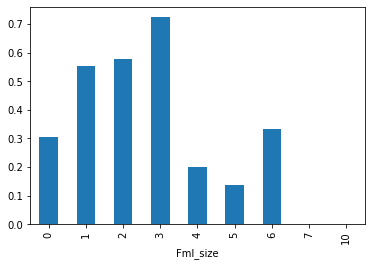

In [101]:
survived_by_Fml_size.plot(kind='bar', subplots=False)

From the graph above we may conclude that those who had families had more chances to survive.

## 2 Preprocess data

First, I want to check the quantity of missing values in train dataset.

In [102]:
missing_df = pd.Series(train.isna().sum(), name='number').to_frame()
missing_df = missing_df.assign(percentage=lambda x: round((x.number/train.shape[0]), 2))
missing_df

,number,percentage
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,177,0.20
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,0,0.00


In general data looks great, except of Age and Cabin columns. Each Cabin value is actually a combination of the Deck name and cabin number. Therefore, we may extract the Deck names because thay might be useful. 

### 2.1 Transform Cabin to Deck

In [103]:
def extract_cabin_type(df):
    df['Cabin'] = df['Cabin'].str.extract('([A-Za-z]+)')

In [104]:
extract_cabin_type(train)
train['Cabin'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

### 2.2 Combine Titles

The next things is Titles from "Name" Column. I want to extract thrm and have a look.

In [105]:
def extract_titel(df):
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.')

In [106]:
extract_titel(train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fml_size,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr


In [107]:
train.groupby(['Title'])['Survived'].value_counts()

Title     Survived
Capt      0             1
Col       0             1
          1             1
Countess  1             1
Don       0             1
Dr        0             4
          1             3
Jonkheer  0             1
Lady      1             1
Major     0             1
          1             1
Master    1            23
          0            17
Miss      1           127
          0            55
Mlle      1             2
Mme       1             1
Mr        0           436
          1            81
Mrs       1            99
          0            26
Ms        1             1
Rev       0             6
Sir       1             1
Name: Survived, dtype: int64

So i have check the meaning of titles on wikipedia to perform binnig on them. Below are the explanations.

* Capt       - military
* Col        - military
* Countess   - English nobility
* Don        - a Spanish, Portuguese, southern Italian, and Filipino nobility title
* Dr         - academic title for medical practitioner / honorific
* Jonkheer   - Netherland's nobility
* Lady       - English nobility/honorific
* Major      - military
* Rev        - a courtesy title for Protestant Christian ministers or pastors / honorific
* Sir        - honorific

In [108]:
def replace_title(df):
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].replace(['Capt', 'Col', 'Major'], 'Military')
    df['Title'] = df['Title'].replace(['Countess','Don', 'Jonkheer', 'Dona'], 'Nobility')
    df['Title'] = df['Title'].replace(['Lady', 'Sir','Rev', 'Dr'], 'Honorific')

In [109]:
replace_title(train)
train.groupby(['Title'])['Survived'].value_counts()

Title      Survived
Honorific  0            10
           1             5
Master     1            23
           0            17
Military   0             3
           1             2
Miss       1           130
           0            55
Mr         0           436
           1            81
Mrs        1           100
           0            26
Nobility   0             2
           1             1
Name: Survived, dtype: int64

### 2.3 Outliers
At this point I want to check for possible outliers.

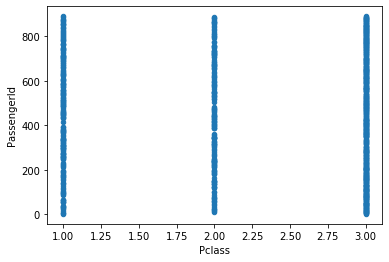

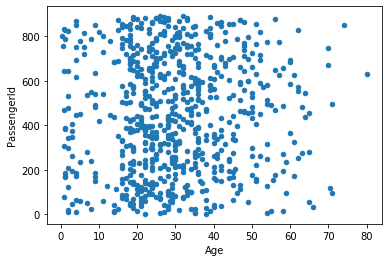

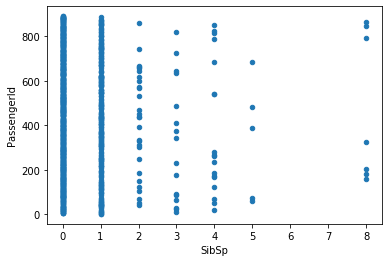

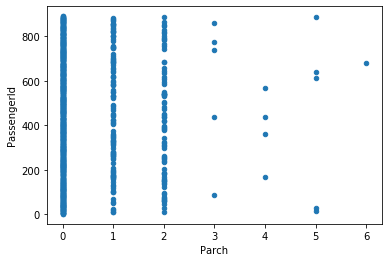

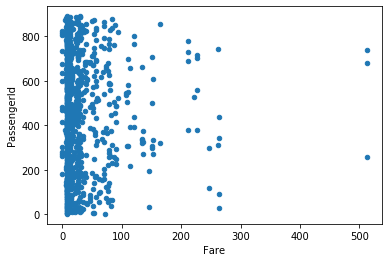

In [110]:
columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
for column in columns:
    train.plot(x=column, y='PassengerId', kind='scatter')
    #sns.boxplot(x=train[column])

In [111]:
train.loc[train['Age'] > 70]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fml_size,Title
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A,C,0,Mr
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,0,Mr
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C,0,Mr
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A,S,0,Mr
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S,0,Mr


According to the Encyclopedia Titanica, [Mr. Algernon Henry Wilson Barkworth] (https://www.encyclopedia-titanica.org/titanic-survivor/algernon-barkworth.html) was 48 y.o. at the moment he stepted on the board of Titanic, not 80. So we will need to re-assign this value later.

There also were people who payed more than 500 for the ticked. Actually, it is not a mistake and was true.

In [112]:
train.loc[train['Fare'] > 300]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fml_size,Title
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,0,Miss
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B,C,1,Mr
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B,C,0,Mr


In [113]:
train.loc[train['PassengerId'] == 69]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fml_size,Title
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.925,NaN,S,6,Miss


In [114]:
train.loc[train['PassengerId'] == 631, 'Age'] = 48
train.loc[train['PassengerId'] == 117, 'Age'] = 66

train.loc[train['PassengerId'] == 69, ['SibSp', 'Parch']] = [0,0]
train.loc[train['PassengerId'] == 259, ['SibSp', 'Parch']] = [0,0]

In [115]:
train.loc[train['Fare'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fml_size,Title
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,0,Mr
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B,S,0,Mr
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,0,Mr
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,0,Mr
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,0,Mr
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,0,Mr
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,0,Mr
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S,0,Mr
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,0,Mr
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,0,Mr


In [116]:
def complimentary_ticket(df):
    df['CTicket'] = 0
    df.loc[df['Fare'] == 0.0, 'CTicket'] = 1

In [117]:
complimentary_ticket(train)
train.loc[train['Fare'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fml_size,Title,CTicket
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,0,Mr,1
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B,S,0,Mr,1
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,0,Mr,1
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,0,Mr,1
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,0,Mr,1
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,0,Mr,1
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,0,Mr,1
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S,0,Mr,1
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,0,Mr,1
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,0,Mr,1


def remove_fair_outliers(df):
    upper = df['Fare'].quantile(0.95)

    df.loc[(df['Fare'] > 300),'Fare'] = 300


remove_fair_outliers(train)
train

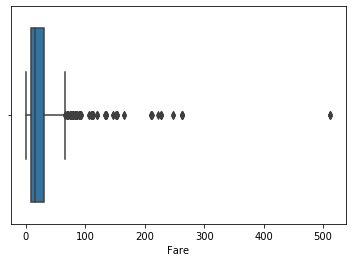

In [118]:
sns.boxplot(x=train['Fare'])

In [119]:
train.loc[train['Fare'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fml_size,Title,CTicket
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,0,Mr,1
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B,S,0,Mr,1
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,0,Mr,1
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,0,Mr,1
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,0,Mr,1
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,0,Mr,1
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,0,Mr,1
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S,0,Mr,1
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,0,Mr,1
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,0,Mr,1


So now, we can fill missing values by median value from the result of grouping values by specific features such as Class, Title and Sex.  

In [120]:
def fill_nan(df):
    df['Age'] = df.groupby(['Pclass', 'Sex', 'Title'])['Age'].transform(lambda x: x.fillna(x.median()))
    df['Embarked'].fillna(df['Embarked'].value_counts().idxmax(), inplace=True)
    df['Fare'] = df.groupby(['Pclass', 'Title'])['Fare'].transform(lambda x: x.fillna(x.median()))
    df['Cabin'].fillna('U', inplace=True)

In [121]:
fill_nan(train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fml_size,Title,CTicket
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1,Mrs,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,0,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1,Mrs,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,0,Mr,0


### 2.4 Binning

In this dataset we do have some features to which we are supposed apply binnig.

The main motivation of binning is to make the model more robust and prevent overfitting, however, it has a cost to the performance. [Medium](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114)

In [122]:
def age_bin(df):
    df['Age'] = df['Age'].astype(int)
    
    df['Age_bin'] = pd.cut(df['Age'], bins=5, labels=["Kid", "Young", "Adult", 'Middle-Aged', "Old"])

In [123]:
age_bin(train)
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fml_size,Title,CTicket,Age_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,U,S,1,Mr,0,Young
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,C,1,Mrs,0,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,U,S,0,Miss,0,Young
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C,S,1,Mrs,0,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,U,S,0,Mr,0,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,U,S,0,Honorific,0,Young
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B,S,0,Miss,0,Young
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,18,1,2,W./C. 6607,23.4500,U,S,3,Miss,0,Young
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C,C,0,Mr,0,Young


In [124]:
survived_by_Age = train.groupby(['Age_bin', 'Sex'])['Survived'].mean()
survived_by_Age

Age_bin      Sex   
Kid          female    0.615385
             male      0.534884
Young        female    0.713287
             male      0.128472
Adult        female    0.812500
             male      0.210843
Middle-Aged  female    0.781250
             male      0.203390
Old          female    1.000000
             male      0.095238
Name: Survived, dtype: float64

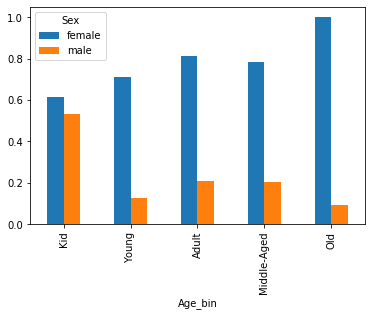

In [125]:
survived_by_Age.unstack(level=1).plot(kind='bar', subplots=False)

### 2.5 Feature engineering

Because wether person traveled alone or with family had an impact on survival chance, I have decided to create new feature "IsAlone".

In [126]:
def travel_alone(df):
    df['IsAlone'] = 1
    df['IsAlone'].loc[df['Fml_size'] > 0] = 0

In [127]:
travel_alone(train)
train.head()

C:\Users\Nami_Kaneko\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fml_size,Title,CTicket,Age_bin,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,U,S,1,Mr,0,Young,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,C,1,Mrs,0,Adult,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,U,S,0,Miss,0,Young,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C,S,1,Mrs,0,Adult,0
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,U,S,0,Mr,0,Adult,1


In [128]:
#encode string values into number categories
def label_encoding(df):
    labelencoder = LabelEncoder()
    columns = ['Sex', 'Embarked', 'Cabin', 'Age_bin', 'Title']
    for column in columns:
        df[column] = labelencoder.fit_transform(df[column])

In [129]:
label_encoding(train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fml_size,Title,CTicket,Age_bin,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,8,2,1,4,0,4,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,2,0,1,5,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,8,2,0,3,0,4,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,2,2,1,5,0,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,8,2,0,4,0,0,1


It might be useful to derive new features from existing ones.

In [130]:
def create_new_features(df):
    df['Sex_Class'] = df['Sex']*df['Pclass']
    df['Sex_Fare']  = df['Sex']*df['Fare']
    df['Sex_Age']   = df['Sex']*df['Age_bin']
    
    df['Class_Age'] = df['Age_bin']*df['Pclass']
    df['Age_Fare']  = df['Age_bin']*df['Fare']
    
    df['Small_Fml'] = df['Fml_size'].map(lambda s: 1 if  s <= 2  else 0)
    df['Avg_Fml']   = df['Fml_size'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    df['Big_Fml']   = df['Fml_size'].map(lambda s: 1 if s >= 5 else 0)

In [131]:
create_new_features(train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_bin,IsAlone,Sex_Class,Sex_Fare,Sex_Age,Class_Age,Age_Fare,Small_Fml,Avg_Fml,Big_Fml
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,...,4,0,3,7.25,4,12,29.0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,...,0,0,0,0.00,0,0,0.0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,...,4,1,0,0.00,0,12,31.7,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,...,0,0,0,0.00,0,0,0.0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,...,0,1,3,8.05,0,0,0.0,1,0,0


Now, I want to use feature correlation across the entire dataset to determine which features are too highly-correlated. Because if such exist they may over-inflate the importance of a single feature.

In [132]:
def corr_to_drop(df):
    
    # Create correlation matrix for just Features to determine different models to test
    corr_matrix = df.corr().abs().round(2)

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find features with correlation greater than 0.90
    cols_to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
    
    return cols_to_drop

In [133]:
cols_to_drop = corr_to_drop(train)
print(cols_to_drop)

['Class_Age']


I will drop 'Class' feature anyway, so there are no highly-correlated values.

In [134]:
def drop_columns(df):
    cols_to_drop = ['Name', 'Age', 'Ticket', 'Fml_size', 'SibSp', 'Parch', 'Cabin', 'Age_bin', 'Title']
    return df.drop(cols_to_drop, axis=1)

In [135]:
train = drop_columns(train)
train.head()

,PassengerId,Survived,Pclass,Sex,Fare,Embarked,CTicket,IsAlone,Sex_Class,Sex_Fare,Sex_Age,Class_Age,Age_Fare,Small_Fml,Avg_Fml,Big_Fml
0,1,0,3,1,7.2500,2,0,0,3,7.25,4,12,29.0,1,0,0
1,2,1,1,0,71.2833,0,0,0,0,0.00,0,0,0.0,1,0,0
2,3,1,3,0,7.9250,2,0,1,0,0.00,0,12,31.7,1,0,0
3,4,1,1,0,53.1000,2,0,0,0,0.00,0,0,0.0,1,0,0
4,5,0,3,1,8.0500,2,0,1,3,8.05,0,0,0.0,1,0,0


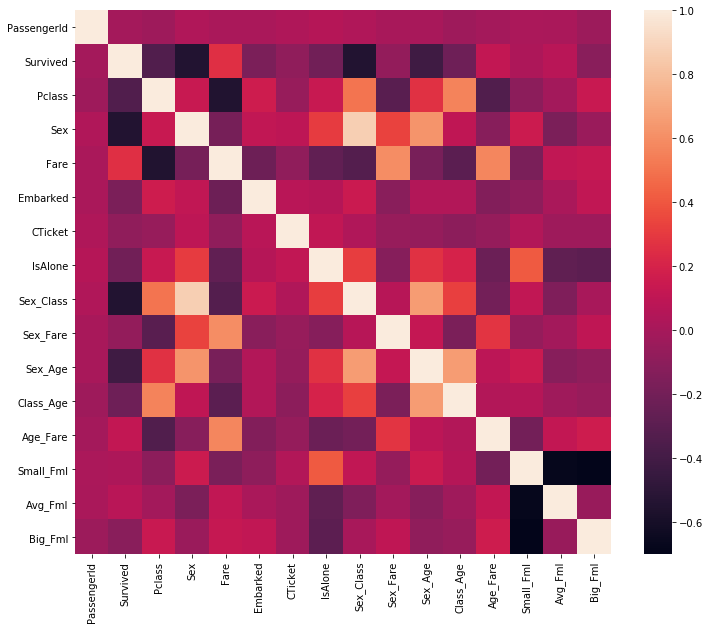

In [136]:
plt.figure(figsize=(12,10))
cor = train.corr()
sns.heatmap(cor)

In [137]:
passengerId = pd.DataFrame(train['PassengerId'].values,columns=['PassengerId'])
train_Y=pd.DataFrame(train['Survived'].values,columns=['Survived'])
train_X=train.drop(['PassengerId','Survived'],axis=1)
train_X.shape

(891, 14)

### 2.6 Log tranformation

In [138]:
def perform_log_transform(df):
    df_log = pd.DataFrame()

    for col in df.columns:
        df_log[col]=(df[col]-df[col].min()+1).transform(np.log)
    return df_log

In [ ]:
train_X = perform_log_transform(train_X)

### 2.7 Scaling dataset

In [139]:
def scale_dataset(df):
    scaler = StandardScaler()
    scale=scaler.fit(df)
    return scaler.transform(df)

In [141]:
X_scaled = scale_dataset(train_X)

## 3 Modeling

### 3.1 PCA for data varience 

In [142]:
def sklearn_pca(data, n_components=None):
    pca = PCA(n_components)
    data_transformed = pca.fit_transform(data)
    return pca, data_transformed

In [143]:
def plot_variance_sklearn(pca):
    exp_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(exp_variance)
    plt.xlabel('No of Components')
    plt.ylabel('Explained Variance')
    plt.title('Explained Variance Ratio')
    plt.grid(b=True)
    plot = plt.show()

In [144]:
pca_model, pca_transformed = sklearn_pca(X_scaled)

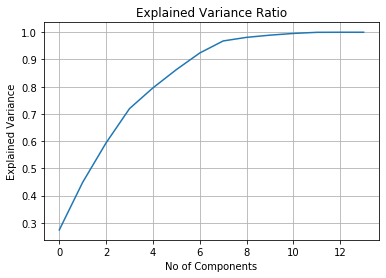

In [145]:
plot_variance_sklearn(pca_model)


We can actiually cover more than 90% of data varience with only 6 features. And we need 10 for 100%

In [146]:
pca_model, pca_transformed = sklearn_pca(X_scaled, 10)

### 3.2 Split dataset into train/validation

In [147]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, train_Y, test_size=0.3)

In [148]:
print(X_train.shape)
print(X_val.shape)

(623, 14)
(268, 14)


In [149]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [150]:
y_pred = lr.predict_proba(X_val)[:,1]
print('Logistic regression ROC-AUC: {:.2f}'.format(roc_auc_score(y_val, y_pred)))

Logistic regression ROC-AUC: 0.87


### 3.3 Benchmark models

Here I will run several different scikit-learn's classifiers, to see what works best.

In [151]:
def model_trainer(model, X_train, y_train, X_val, y_val):
   
    t = time.time()
    model = model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_val)
    
    roc_score = round(roc_auc_score(y_val, y_pred), 2)

    train_time = time.time() - t
    
    return roc_score, train_time

In [152]:
def run_multiple(classifiers, X_train, y_train, X_val, y_val):
    
    result={
    'classifier':[],
    'AUC-ROC score':[],
    'train_time':[]
    }
    for name, classifier in classifiers:
        score, t = model_trainer(classifier, X_train, y_train, X_val, y_val)
        result['classifier'].append(name)
        result['AUC-ROC score'].append(score)
        result['train_time'].append(t)
    results_df = pd.DataFrame.from_dict(result, orient='index').transpose()
    return results_df

In [153]:
classifiers = [
    #("Logistic Regression", LogisticRegression(random_state=42)),
    ("XGBClassifier",xgb.XGBClassifier(random_state=42)),
    ("SVC", SVC(gamma=2, C=1)),
    ("QD Analysis", QuadraticDiscriminantAnalysis()),
    ("Naive Bayes", GaussianNB()),
    ("Nearest Neighbors", KNeighborsClassifier(3)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42)),
    ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=42))
]

In [154]:
run_multiple(classifiers, X_train, y_train, X_val, y_val)

C:\Users\Nami_Kaneko\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,classifier,AUC-ROC score,train_time
0,XGBClassifier,0.8,0.0479012
1,SVC,0.76,0.0139599
2,QD Analysis,0.56,0.00296497
3,Naive Bayes,0.53,0.00199604
4,Nearest Neighbors,0.78,0.0219417
5,Decision Tree,0.72,0.0039885
6,Random Forest,0.79,0.173537
7,AdaBoost,0.81,0.0808094
8,GradientBoostingClassifier,0.81,0.0927515


But why choosing only one model for tunning, if we can use several simultaniously. Therefore, I picked out 4 classifiers with best performance and unify them with Voting Classifier.

### 3.4 Voting Classifier

In [155]:
best_classifiers = [
    ("XGBClassifier",xgb.XGBClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42)),
    ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=42))
]

In [156]:
vot_hard = VotingClassifier(estimators = best_classifiers, voting ='hard') 
vot_hard.fit(X_train, y_train.values.ravel()) 
y_pred = vot_hard.predict(X_val) 

In [157]:
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(vot_hard.score(X_val, y_val)))
print('ROC-AUC: {:.2f}'.format(roc_auc_score(y_val, y_pred)))

Accuracy of logistic regression classifier on validation set: 0.81
ROC-AUC: 0.80


## Hyperparameters tunning


In [158]:
grid_params = [
    #xgb
    [{
        'n_estimators': range(20, 200, 20),
        'max_depth': range(5, 15, 1),
        'eta': [0.05, 0.1, 0.2],
        'min_child_weight': (1, 12, 2)
    }],
    #random forest
    [{
        'n_estimators': range(20, 200, 20),
        'criterion': ['gini', 'entropy'],
        'max_depth': range(5, 15, 1),
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': (1, 13, 2),
        'min_samples_split': range(20, 100, 10)
    }],
    #adaboost
    [{
        'n_estimators': [25, 50, 100, 150, 200],
        'learning_rate' : [0.01,0.05,0.1,0.3,0.5,1]
    }],
    #gb
    [{
        'n_estimators': range(20, 200, 20),
        'max_depth': range(2, 16, 2),
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': (1, 13, 2),
        'min_samples_split': range(20, 100, 10),
        'subsample':[0.6,0.7,0.8],
        'learning_rate':[0.05, 0.1]
    }]
]

In [159]:
for estimator, grid_dict in zip(best_classifiers, grid_params):
    best_model = GridSearchCV(estimator = estimator[1],
                         param_grid = grid_dict,
                         scoring = "roc_auc",
                         cv = 5,
                         n_jobs=-1)
    t = time.time()
    best_model.fit(X_train, y_train.values.ravel())
    print(f'{estimator[0]} - done in: {time.time() - t}')
    best_param = best_model.best_params_
    estimator[1].set_params(**best_param) 
    

XGBClassifier - done in: 74.43746614456177
Random Forest - done in: 2301.2850410938263
AdaBoost - done in: 5.984729051589966
GradientBoostingClassifier - done in: 3077.0796360969543


In [161]:
vot_hard = VotingClassifier(estimators = best_classifiers, voting ='hard') 
vot_hard.fit(X_train, y_train.values.ravel()) 
y_pred = vot_hard.predict(X_val)

In [162]:
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(vot_hard.score(X_val, y_val)))
print('ROC-AUC: {:.2f}'.format(roc_auc_score(y_val, y_pred)))

Accuracy of logistic regression classifier on validation set: 0.82
ROC-AUC: 0.80


### Extra: Try Simple FNN

In [177]:
import torch
import torch.nn.functional as F
from torch import nn, optim

class BinaryClassifier(nn.Module):

    def __init__(self, input_features, hidden_dim, output_dim):
        
        super(BinaryClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_features, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, output_dim)
        self.drop = nn.Dropout(0.3)

        self.sig = nn.Sigmoid()
    
    def forward(self, x):
       
        out = F.relu(self.fc1(x)) # activation on hidden layer
        out = self.drop(out)
        out = self.fc2(out)
        #out = self.drop(out)
        out = self.fc3(out)
        out = self.drop(out)
        
        return self.sig(out)


In [178]:
#X_train, X_val, y_train, y_val = train_test_split(X_scaled, train_Y, test_size=0.3)

In [179]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_val = torch.from_numpy(X_val).float()
y_val = torch.squeeze(torch.from_numpy(y_val.to_numpy()).float())

In [180]:
nn_model = BinaryClassifier(X_train.shape[1], 50, 1)

In [181]:
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

In [182]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device {}.".format(device))

Using device cpu.


In [183]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_val = X_val.to(device)
y_val = y_val.to(device)

In [184]:
nn_model = nn_model.to(device)
criterion = criterion.to(device)

In [185]:
for epoch in range(1, 30001):
    nn_model.train() # Make sure that the model is in training mode.

    total_loss = 0

    optimizer.zero_grad()

        # get predictions from model
    y_pred = nn_model(X_train)
            
        # perform backprop
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
            
    total_loss += loss.data.item()
    
    if epoch%1000 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, round(total_loss, 4)))

C:\Users\Nami_Kaneko\anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([623])) that is different to the input size (torch.Size([623, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 1000, Loss: 0.4445
Epoch: 2000, Loss: 0.4378
Epoch: 3000, Loss: 0.4192
Epoch: 4000, Loss: 0.3647
Epoch: 5000, Loss: 0.4023
Epoch: 6000, Loss: 0.4075
Epoch: 7000, Loss: 0.3827
Epoch: 8000, Loss: 0.3951
Epoch: 9000, Loss: 0.3782
Epoch: 10000, Loss: 0.3903
Epoch: 11000, Loss: 0.3928
Epoch: 12000, Loss: 0.3844
Epoch: 13000, Loss: 0.3831
Epoch: 14000, Loss: 0.3636
Epoch: 15000, Loss: 0.3796
Epoch: 16000, Loss: 0.3632
Epoch: 17000, Loss: 0.4035
Epoch: 18000, Loss: 0.3925
Epoch: 19000, Loss: 0.3663
Epoch: 20000, Loss: 0.3637
Epoch: 21000, Loss: 0.3649
Epoch: 22000, Loss: 0.3862
Epoch: 23000, Loss: 0.3948
Epoch: 24000, Loss: 0.3923
Epoch: 25000, Loss: 0.3819
Epoch: 26000, Loss: 0.379
Epoch: 27000, Loss: 0.38
Epoch: 28000, Loss: 0.3841
Epoch: 29000, Loss: 0.3924
Epoch: 30000, Loss: 0.4052


In [186]:
classes = ['Not survived', 'Survived']

y_pred = nn_model(X_val)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()

print('ROC-AUC: {:.2f}'.format(roc_auc_score(y_val, y_pred)))
print(classification_report(y_val, y_pred, target_names=classes))

ROC-AUC: 0.72
              precision    recall  f1-score   support

Not survived       0.86      0.61      0.72       166
    Survived       0.57      0.83      0.68       102

    accuracy                           0.70       268
   macro avg       0.71      0.72      0.70       268
weighted avg       0.75      0.70      0.70       268



This NN is not as much efficient as the rest of the ML algorithms used before. However, it is a good idea to experiment more with NN solutions for this problem.

## Predicting values from test dataset

In [168]:
test = pd.read_csv('data/test.csv', sep=',')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [169]:
passengerId = test['PassengerId']
test = test.drop(['PassengerId'],axis=1)
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [170]:
def preprocess(df):
    count_family_members(df)
    extract_cabin_type(df)
    extract_titel(df)
    replace_title(df)
    complimentary_ticket(df)
    fill_nan(df)
    age_bin(df)
    travel_alone(df)
    label_encoding(df)
    create_new_features(df)
    print(df.shape)
    df = drop_columns(df)
    print(set(train_X.columns) - set(df.columns))
    df = perform_log_transform(df)
    return scale_dataset(df)

In [171]:
test = preprocess(test)
test

(418, 23)
<bound method NDFrame.head of      Pclass  Sex      Fare  Embarked  CTicket  IsAlone  Sex_Class  Sex_Fare  \
0         3    1    7.8292         1        0        1          3    7.8292   
1         3    0    7.0000         2        0        0          0    0.0000   
2         2    1    9.6875         1        0        1          2    9.6875   
3         3    1    8.6625         2        0        1          3    8.6625   
4         3    0   12.2875         2        0        0          0    0.0000   
..      ...  ...       ...       ...      ...      ...        ...       ...   
413       3    1    8.0500         2        0        1          3    8.0500   
414       1    0  108.9000         0        0        1          0    0.0000   
415       3    1    7.2500         2        0        1          3    7.2500   
416       3    1    8.0500         2        0        1          3    8.0500   
417       3    1   22.3583         0        0        0          3   22.3583   

     Sex_Ag

C:\Users\Nami_Kaneko\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


array([[ 0.81526902,  0.75592895, -0.86496522, ...,  0.29755952,
        -0.22999288, -0.17916128],
       [ 0.81526902, -1.32287566, -0.96700215, ...,  0.29755952,
        -0.22999288, -0.17916128],
       [-0.07469361,  0.75592895, -0.66734253, ...,  0.29755952,
        -0.22999288, -0.17916128],
       ...,
       [ 0.81526902,  0.75592895, -0.93516526, ...,  0.29755952,
        -0.22999288, -0.17916128],
       [ 0.81526902,  0.75592895, -0.83940982, ...,  0.29755952,
        -0.22999288, -0.17916128],
       [ 0.81526902,  0.75592895,  0.14160153, ...,  0.29755952,
        -0.22999288, -0.17916128]])

In [172]:
solution_pred = vot_hard.predict(test)

In [173]:
passengerId

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [174]:
data = {'Survived': solution_pred}
solution_df = pd.DataFrame(index=passengerId, data=data)

In [175]:
solution_df

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


In [176]:
solution_df.to_csv("./submissions/vote_hard_sFinal.csv")